## <span style='color:green'> Task 3 : Data Exploration & Preprocessing, Topic Modeling & Sentiment Analysis</span>

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier

In [87]:
# read the csv file generated from clean_tweets_dataframe.py
tweets_df = pd.read_csv("data/clean_processed_tweet_data.csv")

# 3.1 Data Exploration

In [88]:
# display the first 5 rows from our dataset
tweets_df.head()

,Unnamed: 0,created_at,source,original_text,subjectivity,polarity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,0,2022-08-07 22:31:20+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @i_ameztoy: Extra random image (I):\n\nLets...,0.190625,-1.250000e-01,en,4,2,i_ameztoy,20497,2621,NaN,City,i_ameztoy,NaN
1,1,2022-08-07 22:31:16+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @IndoPac_Info: #China's media explains the ...,0.100000,-1.000000e-01,en,691,201,ZIisq,65,272,NaN,"China, Taiwan",IndoPac_Info,NaN
2,2,2022-08-07 22:31:07+00:00,"<a href=""http://twitter.com/download/android"" ...","China even cut off communication, they don't a...",0.000000,0.000000e+00,en,0,0,Fin21Free,85,392,NaN,XiJinping,ZelenskyyUa,Netherlands
3,3,2022-08-07 22:31:06+00:00,"<a href=""http://twitter.com/download/android"" ...","Putin to #XiJinping : I told you my friend, Ta...",0.350000,1.000000e-01,en,0,0,Fin21Free,85,392,NaN,XiJinping,NaN,Netherlands
4,4,2022-08-07 22:31:04+00:00,"<a href=""http://twitter.com/download/iphone"" r...","RT @ChinaUncensored: I’m sorry, I thought Taiw...",0.556250,-6.938894e-18,en,1521,381,VizziniDolores,910,2608,NaN,NaN,ChinaUncensored,"Ayent, Schweiz"


In [89]:
# display dataframe information
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 0 to 21999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          22000 non-null  int64  
 1   created_at          22000 non-null  object 
 2   source              22000 non-null  object 
 3   original_text       22000 non-null  object 
 4   subjectivity        22000 non-null  float64
 5   polarity            22000 non-null  float64
 6   lang                22000 non-null  object 
 7   favorite_count      22000 non-null  int64  
 8   retweet_count       22000 non-null  int64  
 9   original_author     22000 non-null  object 
 10  followers_count     22000 non-null  int64  
 11  friends_count       22000 non-null  int64  
 12  possibly_sensitive  6191 non-null   object 
 13  hashtags            19141 non-null  object 
 14  user_mentions       18698 non-null  object 
 15  place               12107 non-null  object 
dtypes: f

In [90]:
# check null values
tweets_df.isna()

,Unnamed: 0,created_at,source,original_text,subjectivity,polarity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True
1,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True
2,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False
4,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21995,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
21996,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
21997,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
21998,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


In [91]:
# shape of the dataframe
tweets_df.shape

(22000, 16)

In [92]:
# show columns of the dataframe
tweets_df.columns

Index(['Unnamed: 0', 'created_at', 'source', 'original_text', 'subjectivity',
       'polarity', 'lang', 'favorite_count', 'retweet_count',
       'original_author', 'followers_count', 'friends_count',
       'possibly_sensitive', 'hashtags', 'user_mentions', 'place'],
      dtype='object')

In [93]:
# drop empty values
tweets_df.dropna()

,Unnamed: 0,created_at,source,original_text,subjectivity,polarity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
5,5,2022-08-07 22:31:02+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @benedictrogers: We must not let this happe...,0.500000,0.200000,en,116,36,GraceCh15554845,207,54,False,Taiwan,benedictrogers,"Melbourne, Victoria"
36,36,2022-08-07 22:26:25+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @ChinaInfo777: #PinkFloyd Roger Waters tell...,0.000000,0.000000,en,23,5,nhohn2011,870,508,False,"PinkFloyd, Taiwan, China",ChinaInfo777,"Florida, USA"
39,39,2022-08-07 22:25:37+00:00,"<a href=""http://twitter.com/download/android"" ...","RT @WilliamYang120: ""For too long, #Taiwan has...",0.200000,-0.025000,en,311,84,hoggothoaryhost,44,60,False,Taiwan,WilliamYang120,Hong Kong
43,43,2022-08-07 22:25:05+00:00,"<a href=""https://help.twitter.com/en/using-twi...",RT @odisseoisback: #Corfu #Greece🇬🇷\n#Summer #...,0.000000,0.000000,en,0,2,hephaistos_ai,4161,208,False,"Corfu, Greece, Summer, Beaches, Travel, Excurs...",odisseoisback,Paris
48,48,2022-08-07 22:24:44+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @benedictrogers: We must not let this happe...,0.500000,0.200000,en,116,36,hoggothoaryhost,44,60,False,Taiwan,benedictrogers,Hong Kong
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21981,21981,2022-08-06 18:04:09+00:00,"<a href=""https://mobile.twitter.com"" rel=""nofo...",RT @jenniferatntd: Head of #Taiwan's #missile ...,0.400000,-0.200000,en,194,99,threadmaxwhispe,657,864,False,"Taiwan, missile",jenniferatntd,Land of Ethan South Dakota
21989,21989,2022-08-06 18:03:48+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Minister Wu is crystal clear in his @BBCNews i...,0.419444,0.158333,en,0,0,TECO_Toronto,955,202,False,"Taiwan, StandWithTaiwan, DefendDemocracy","BBCNews, SpeakerPelosi","Toronto, Canada"
21990,21990,2022-08-06 18:03:47+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @SpokespersonCHN: #PLA Live-fire military d...,0.250000,-0.100000,en,2611,405,mumaralid,1164,605,True,"PLA, Taiwan",SpokespersonCHN,Driver
21992,21992,2022-08-06 18:03:33+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @jenniferatntd: Head of #Taiwan's #missile ...,0.400000,-0.200000,en,194,99,9thousandbytes,401,858,False,"Taiwan, missile",jenniferatntd,Northern Virginia


In [94]:
tweets_df["source"] = tweets_df["source"].str.replace(r"(\s*\<.*?\>\s*)", " ", regex=True).str.strip()


In [95]:
tweets_df

,Unnamed: 0,created_at,source,original_text,subjectivity,polarity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,0,2022-08-07 22:31:20+00:00,Twitter for Android,RT @i_ameztoy: Extra random image (I):\n\nLets...,0.190625,-1.250000e-01,en,4,2,i_ameztoy,20497,2621,NaN,City,i_ameztoy,NaN
1,1,2022-08-07 22:31:16+00:00,Twitter for Android,RT @IndoPac_Info: #China's media explains the ...,0.100000,-1.000000e-01,en,691,201,ZIisq,65,272,NaN,"China, Taiwan",IndoPac_Info,NaN
2,2,2022-08-07 22:31:07+00:00,Twitter for Android,"China even cut off communication, they don't a...",0.000000,0.000000e+00,en,0,0,Fin21Free,85,392,NaN,XiJinping,ZelenskyyUa,Netherlands
3,3,2022-08-07 22:31:06+00:00,Twitter for Android,"Putin to #XiJinping : I told you my friend, Ta...",0.350000,1.000000e-01,en,0,0,Fin21Free,85,392,NaN,XiJinping,NaN,Netherlands
4,4,2022-08-07 22:31:04+00:00,Twitter for iPhone,"RT @ChinaUncensored: I’m sorry, I thought Taiw...",0.556250,-6.938894e-18,en,1521,381,VizziniDolores,910,2608,NaN,NaN,ChinaUncensored,"Ayent, Schweiz"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21995,21995,2022-08-06 18:03:29+00:00,Twitter for Android,RT @IndoPac_Info: A good infographic of #China...,0.600000,7.000000e-01,en,507,183,VandelayT,62,471,False,"China, Taiwan, ChinaTaiwanCrisis",IndoPac_Info,NaN
21996,21996,2022-08-06 18:03:27+00:00,Twitter for Android,RT @IndoPac_Info: A good infographic of #China...,0.600000,7.000000e-01,en,507,183,sashalenik,94,1751,False,"China, Taiwan, ChinaTaiwanCrisis",IndoPac_Info,Gelendzhik
21997,21997,2022-08-06 18:03:27+00:00,Twitter for Android,@Reuters Thanks #Pelosi smart move.,0.421429,2.071429e-01,en,0,0,ZeitounRimal,88,0,NaN,Pelosi,Reuters,🇺🇲🇷🇺🇺🇦🇫🇷🇦🇪🇮🇱🏳️‍🌈
21998,21998,2022-08-06 18:03:26+00:00,Twitter for Android,RT @IndoPac_Info: #Taiwan people's Desire for ...,0.350000,5.000000e-02,en,199,67,SazzyCowgirl1,537,317,NaN,"Taiwan, China",IndoPac_Info,"Oregon, USA"


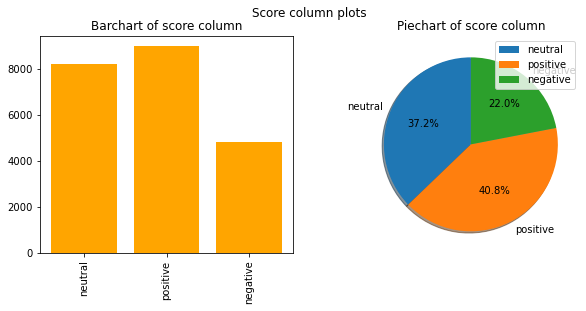

In [96]:
# Visualize polarity column using piechart and barchart
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['neutral', 'positive', 'negative']

neutral_count =  len(tweets_df[tweets_df['polarity'] > 0])
positive_count = len(tweets_df[tweets_df['polarity'] == 0])
negative_count = len(tweets_df[tweets_df['polarity'] <0])
sizes = [neutral_count, positive_count, negative_count]
# Create a figure for 2 subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize = (10,4))

# Create a bar plot of score column
ax[0].bar(x=labels, height=[neutral_count, positive_count, negative_count], color='orange')
ax[0].set_title('Barchart of score column')
ax[0].set_xticklabels(labels, rotation=90)

# Create a pie chart of score column based on neutral, positive or negative

ax[1].pie(sizes,labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax[1].set_title('Piechart of score column')
ax[1].legend(labels)

# Add a title to the Figure
fig.suptitle('Score column plots')

# Show the figure
fig.show()

# 3.2 Data Preprocessing

In [97]:
# add new column named clean_text to store cleaned original text
tweets_df.insert(4,column = 'clean_text',value = tweets_df['original_text'])

In [98]:
tweets_df.head()

,Unnamed: 0,created_at,source,original_text,clean_text,subjectivity,polarity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,0,2022-08-07 22:31:20+00:00,Twitter for Android,RT @i_ameztoy: Extra random image (I):\n\nLets...,RT @i_ameztoy: Extra random image (I):\n\nLets...,0.190625,-1.250000e-01,en,4,2,i_ameztoy,20497,2621,NaN,City,i_ameztoy,NaN
1,1,2022-08-07 22:31:16+00:00,Twitter for Android,RT @IndoPac_Info: #China's media explains the ...,RT @IndoPac_Info: #China's media explains the ...,0.100000,-1.000000e-01,en,691,201,ZIisq,65,272,NaN,"China, Taiwan",IndoPac_Info,NaN
2,2,2022-08-07 22:31:07+00:00,Twitter for Android,"China even cut off communication, they don't a...","China even cut off communication, they don't a...",0.000000,0.000000e+00,en,0,0,Fin21Free,85,392,NaN,XiJinping,ZelenskyyUa,Netherlands
3,3,2022-08-07 22:31:06+00:00,Twitter for Android,"Putin to #XiJinping : I told you my friend, Ta...","Putin to #XiJinping : I told you my friend, Ta...",0.350000,1.000000e-01,en,0,0,Fin21Free,85,392,NaN,XiJinping,NaN,Netherlands
4,4,2022-08-07 22:31:04+00:00,Twitter for iPhone,"RT @ChinaUncensored: I’m sorry, I thought Taiw...","RT @ChinaUncensored: I’m sorry, I thought Taiw...",0.556250,-6.938894e-18,en,1521,381,VizziniDolores,910,2608,NaN,NaN,ChinaUncensored,"Ayent, Schweiz"


In [99]:
# add new column named sentimnt to where the text is positive,negative or neutral
# tweets_df.insert(7,column = 'sentiment',value = tweets_df['polarity'])
tweets_df

,Unnamed: 0,created_at,source,original_text,clean_text,subjectivity,polarity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,0,2022-08-07 22:31:20+00:00,Twitter for Android,RT @i_ameztoy: Extra random image (I):\n\nLets...,RT @i_ameztoy: Extra random image (I):\n\nLets...,0.190625,-1.250000e-01,en,4,2,i_ameztoy,20497,2621,NaN,City,i_ameztoy,NaN
1,1,2022-08-07 22:31:16+00:00,Twitter for Android,RT @IndoPac_Info: #China's media explains the ...,RT @IndoPac_Info: #China's media explains the ...,0.100000,-1.000000e-01,en,691,201,ZIisq,65,272,NaN,"China, Taiwan",IndoPac_Info,NaN
2,2,2022-08-07 22:31:07+00:00,Twitter for Android,"China even cut off communication, they don't a...","China even cut off communication, they don't a...",0.000000,0.000000e+00,en,0,0,Fin21Free,85,392,NaN,XiJinping,ZelenskyyUa,Netherlands
3,3,2022-08-07 22:31:06+00:00,Twitter for Android,"Putin to #XiJinping : I told you my friend, Ta...","Putin to #XiJinping : I told you my friend, Ta...",0.350000,1.000000e-01,en,0,0,Fin21Free,85,392,NaN,XiJinping,NaN,Netherlands
4,4,2022-08-07 22:31:04+00:00,Twitter for iPhone,"RT @ChinaUncensored: I’m sorry, I thought Taiw...","RT @ChinaUncensored: I’m sorry, I thought Taiw...",0.556250,-6.938894e-18,en,1521,381,VizziniDolores,910,2608,NaN,NaN,ChinaUncensored,"Ayent, Schweiz"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21995,21995,2022-08-06 18:03:29+00:00,Twitter for Android,RT @IndoPac_Info: A good infographic of #China...,RT @IndoPac_Info: A good infographic of #China...,0.600000,7.000000e-01,en,507,183,VandelayT,62,471,False,"China, Taiwan, ChinaTaiwanCrisis",IndoPac_Info,NaN
21996,21996,2022-08-06 18:03:27+00:00,Twitter for Android,RT @IndoPac_Info: A good infographic of #China...,RT @IndoPac_Info: A good infographic of #China...,0.600000,7.000000e-01,en,507,183,sashalenik,94,1751,False,"China, Taiwan, ChinaTaiwanCrisis",IndoPac_Info,Gelendzhik
21997,21997,2022-08-06 18:03:27+00:00,Twitter for Android,@Reuters Thanks #Pelosi smart move.,@Reuters Thanks #Pelosi smart move.,0.421429,2.071429e-01,en,0,0,ZeitounRimal,88,0,NaN,Pelosi,Reuters,🇺🇲🇷🇺🇺🇦🇫🇷🇦🇪🇮🇱🏳️‍🌈
21998,21998,2022-08-06 18:03:26+00:00,Twitter for Android,RT @IndoPac_Info: #Taiwan people's Desire for ...,RT @IndoPac_Info: #Taiwan people's Desire for ...,0.350000,5.000000e-02,en,199,67,SazzyCowgirl1,537,317,NaN,"Taiwan, China",IndoPac_Info,"Oregon, USA"


In [100]:
# 
tweets_df = tweets_df[['original_text','clean_text','polarity']]

In [101]:
def text_category (polarity):
    if polarity > 0:
        return 'positive'
    if polarity < 0:
        return 'negative'
    else:
        return 'neutral'

In [102]:
score= pd.Series([text_category(row_value) for row_value in tweets_df['polarity']])
tweets_df = pd.concat([tweets_df, score.rename('sentiment')], axis=1)
tweets_df.head()

,original_text,clean_text,polarity,sentiment
0,RT @i_ameztoy: Extra random image (I):\n\nLets...,RT @i_ameztoy: Extra random image (I):\n\nLets...,-1.250000e-01,negative
1,RT @IndoPac_Info: #China's media explains the ...,RT @IndoPac_Info: #China's media explains the ...,-1.000000e-01,negative
2,"China even cut off communication, they don't a...","China even cut off communication, they don't a...",0.000000e+00,neutral
3,"Putin to #XiJinping : I told you my friend, Ta...","Putin to #XiJinping : I told you my friend, Ta...",1.000000e-01,positive
4,"RT @ChinaUncensored: I’m sorry, I thought Taiw...","RT @ChinaUncensored: I’m sorry, I thought Taiw...",-6.938894e-18,negative


In [103]:
#pip install gensim

In [104]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
from pprint import pprint
import string
import re
import emoji
import nltk
#nltk.download('words')
words = set(nltk.corpus.words.words())
from nltk.corpus import stopwords

stop = stopwords.words('english')

In [105]:

def cleaner(tweet):
    # remove all single characters
    tweet= re.sub(r'\s+[a-zA-Z]\s+', ' ', tweet)

    # Remove single characters from the start
    tweet = re.sub(r'\^[a-zA-Z]\s+', ' ', tweet) 

    # Substituting multiple spaces with single space
    tweet = re.sub(r'\s+', ' ', tweet, flags=re.I)

    tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet = " ".join(tweet.split())
    tweet = ''.join(c for c in tweet if c not in emoji.UNICODE_EMOJI) #Remove Emojis
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) \
         if w.lower() in words or not w.isalpha())
    return tweet

tweets_df['clean_text'] = tweets_df['original_text'].map(lambda x: cleaner(x))
tweets_df.head()

,original_text,clean_text,polarity,sentiment
0,RT @i_ameztoy: Extra random image (I):\n\nLets...,: Extra random image ( I ): focus in one very ...,-1.250000e-01,negative
1,RT @IndoPac_Info: #China's media explains the ...,: China ' s media the military for each area o...,-1.000000e-01,negative
2,"China even cut off communication, they don't a...","China even cut off communication , they don ' ...",0.000000e+00,neutral
3,"Putin to #XiJinping : I told you my friend, Ta...","to : told you my friend , will be vassal state...",1.000000e-01,positive
4,"RT @ChinaUncensored: I’m sorry, I thought Taiw...",": I ’ m sorry , thought was an independent cou...",-6.938894e-18,negative


In [106]:
class PrepareData:
  def __init__(self,df):
    self.df=df
    
  def preprocess_data(self):
    #tweets_df = self.df.loc[self.df['lang'] =="en"]

    
    #text Preprocessing
    tweets_df['clean_text']=tweets_df['clean_text'].astype(str)
    tweets_df['clean_text'] = tweets_df['clean_text'].apply(lambda x: x.lower())
    tweets_df['clean_text']= tweets_df['clean_text'].apply(lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation)))
    
    #Converting tweets to list of words For feature engineering
    sentence_list = [tweet for tweet in tweets_df['clean_text']]
    word_list = [sent.split() for sent in sentence_list]
    # print(word_list)

    #Create dictionary which contains Id and word 
    word_to_id = corpora.Dictionary(word_list) #generate unique tokens
    #  we can see the word to unique integer mapping
    # print(word_to_id.token2id)
    # using bag of words(bow), we create a corpus that contains the word id and its frequency in each document.
    corpus_1= [word_to_id.doc2bow(tweet) for tweet in word_list]
    # TFIDF

    return tweets_df['clean_text'],word_list, word_to_id, corpus_1

In [107]:
PrepareData_obj=PrepareData(tweets_df)
tweets_df['clean_text'],word_list ,id2word,corpus=PrepareData_obj.preprocess_data()

In [108]:
#tweets_df['clean_text'] = tweets_df['clean_text'].apply(lambda x: [item for item in x if item not in stop])
#tweets_df['clean_text'] = tweets_df['clean_text'].str.replace(r'\b\w\b','').str.replace(r'\s+', ' ')
#print(corpus)
tweets_df

,original_text,clean_text,polarity,sentiment
0,RT @i_ameztoy: Extra random image (I):\n\nLets...,"[ , e, x, r, , r, n, , g, e, , , , , f, ...",-1.250000e-01,negative
1,RT @IndoPac_Info: #China's media explains the ...,"[ , c, h, n, , , , e, , h, e, , l, r, , ...",-1.000000e-01,negative
2,"China even cut off communication, they don't a...","[c, h, n, , e, v, e, n, , c, u, , f, f, , ...",0.000000e+00,neutral
3,"Putin to #XiJinping : I told you my friend, Ta...","[ , , l, , u, , , f, r, e, n, , , w, l, ...",1.000000e-01,positive
4,"RT @ChinaUncensored: I’m sorry, I thought Taiw...","[ , , ’, , , r, r, , , h, u, g, h, , w, ...",-6.938894e-18,negative
...,...,...,...,...
21995,RT @IndoPac_Info: A good infographic of #China...,"[ , g, , f, , c, h, n, , , , l, e, , n, ...",7.000000e-01,positive
21996,RT @IndoPac_Info: A good infographic of #China...,"[ , g, , f, , c, h, n, , , , l, e, , n, ...",7.000000e-01,positive
21997,@Reuters Thanks #Pelosi smart move.,"[h, n, k, , r, , v, e, ]",2.071429e-01,positive
21998,RT @IndoPac_Info: #Taiwan people's Desire for ...,"[ , p, e, p, l, e, , , , e, r, e, , f, r, ...",5.000000e-02,positive


In [109]:
id_words = [[(id2word[id], count) for id, count in line] for line in corpus]

In [110]:
# print(id_words)

# 3.3 Topic Modelling using Latent Dirichlet Allocation(LDA)
#### The purpose of LDA is mapping each teweets in our corpus to a set of topics which covers a good deal of the words in the tweet


In [111]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
pprint(lda_model.print_topics())

In [ ]:
pprint(lda_model.show_topics(formatted=False))

### Model Analysis 

In [ ]:
# Compute Perplexity

#It's a measure of how good the model is. The lower the better. Perplexity is a negative value
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
doc_lda = lda_model[corpus]

In [ ]:
# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model, texts=word_list, dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('\n Ldamodel Coherence Score/Accuracy on Tweets: ', coherence_lda)

In [ ]:
# %pip install pyLDAvis 

In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
LDAvis_prepared

In [ ]:
# !pip install wordcloud

In [ ]:
import sys
print(sys.executable)
from wordcloud import WordCloud

In [ ]:
long_string = ','.join(list(tweets_df['clean_text'].values))

wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

# 3.4 Sentiment Analysis

In [ ]:
import numpy as np 
import pandas as pd 
import re
import nltk 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
# # plot params
# plot_size = plt.rcParams["figure.figsize"] 
# plot_size[0] = 8
# plot_size[1] = 6
# plt.rcParams["figure.figsize"] = plot_size 

In [ ]:
# # number of tweets for each airline
# sns.set(rc={'figure.figsize':(14,10)})
# tweets_df.polarity.value_counts().plot(kind='pie', autopct='%1.0f%%')

In [ ]:
# # Distribution of sentiments across all the tweets.
# sns.set(rc={'figure.figsize':(14,10)})
# tweets_df.sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])

In [ ]:
# sns.set(rc={'figure.figsize':(12,8)})
# sentiment = tweets_df.groupby(['Polarity', 'Sentiment']).sentiment.count().unstack()
# sentiment.plot(kind='bar')

### 3.4.1 Sentiment Analysis with Random Forest

In [ ]:
# Selecting the feature and the label
features = tweets_df.iloc[:, 1].values
labels = tweets_df.iloc[:, 3].values

print(features)

In [ ]:
# Data Cleaning using regular expression
processed_features = []

for sentence in range(0, len(features)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)


In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

### Unigram

In [ ]:
vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features_vectorized = vectorizer.fit_transform(processed_features).toarray()

In [ ]:
# split the dataset into training(80%) and testing(20%)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(processed_features_vectorized, labels, test_size=0.2, random_state=0)

In [ ]:
# train the dataset with random forest algorirhm
from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)

In [ ]:
# make prediction with trained model
predictions = text_classifier.predict(X_test)

In [ ]:
predictions[:10]

In [ ]:
# evaluate the model trained with random forest
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, predictions))

### Bigram

In [ ]:
vectorizer_bigram = TfidfVectorizer (max_features=2189, min_df=7, max_df=0.8, stop_words=stopwords.words('english'),ngram_range = (2,2))
processed_features_vectorized_bigram = vectorizer_bigram.fit_transform(processed_features).toarray()

In [ ]:
# split the dataset into training(80%) and testing(20%)
X_train, X_test, y_train, y_test = train_test_split(processed_features_vectorized_bigram, labels, test_size=0.2, random_state=0)

In [ ]:
text_classifier_bigram = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier_bigram.fit(X_train, y_train)

In [ ]:
# make prediction with trained model
predictions = text_classifier.predict(X_test)

In [ ]:
# evaluate the model trained with random forest
print(accuracy_score(y_test, predictions))

### Sentiment Analysis with SGD

In [ ]:
X = tweets_df['clean_text']
y = tweets_df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
print(X_train.size)
print(X_test.size)
print(y_train.size)
print(y_test.size)

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import plot_confusion_matrix

In [ ]:
# scaling the input
clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-2))

In [ ]:
count_vect = CountVectorizer(1,2)
#X_train = X_train.replace(np.nan, '', regex=True)
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts = X_train_counts.toarray()

In [ ]:
clf.fit(X_train_counts, y_train)

In [ ]:
X_test = X_test.replace(np.nan, '', regex=True)
# use transform not fit_transform
X_test_counts = count_vect.transform(X_test)
X_test_counts = X_test_counts.toarray()
# prediction = clf.prevaluedict(X_test_counts)
prediction = clf.predict(X_test_counts)

In [ ]:
# making prediction
prediction = clf.predict(X_test_counts)

In [ ]:
np.mean(prediction == y_test)

In [ ]:
plot_confusion_matrix(clf, X_test, y_test, display_labels = ['negative', 'positive','neutral'])
plt.suptitle('Confusion Matrix')
plt.show()

### Sentiment Analysis with Naive Bayes